In [31]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [32]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.tools.retriever import create_retriever_tool

In [33]:
urls = [
    "https://medium.com/@aleixlopez/introduction-to-ai-agents-62a790d0bc22",
    "https://medium.com/@aleixlopez/introduction-to-embeddings-vector-stores-c04fe3d11953",
    "https://medium.com/@aleixlopez/introduction-to-prompt-engineering-16fb3cbfb031"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://medium.com/@aleixlopez/introduction-to-ai-agents-62a790d0bc22', 'title': 'Introduction to AI Agents. Architecture, Tools, and Implementation | by Aleix López Pascual | Medium', 'description': 'Discover the power of AI agents and how they extend the capabilities of Large Language Models (LLMs). Learn about their architecture, core components, and real-world applications in this comprehensive guide.', 'language': 'en'}, page_content='Introduction to AI Agents. Architecture, Tools, and Implementation | by Aleix López Pascual | MediumSitemapOpen in appSign upSign inMedium LogoWriteSign upSign inIntroduction to AI AgentsArchitecture, Tools, and ImplementationAleix López Pascual10 min read·Jan 12, 2025--3ListenShareArtificial intelligence continues to reshape the way we live and work. In the past years, Large Language Models (LLMs), such as ChatGPT, have captivated the world with their ability to understand and generate human-like text. They are master

In [34]:
docs_list = [item for sublist in docs for item in sublist]
docs_list

[Document(metadata={'source': 'https://medium.com/@aleixlopez/introduction-to-ai-agents-62a790d0bc22', 'title': 'Introduction to AI Agents. Architecture, Tools, and Implementation | by Aleix López Pascual | Medium', 'description': 'Discover the power of AI agents and how they extend the capabilities of Large Language Models (LLMs). Learn about their architecture, core components, and real-world applications in this comprehensive guide.', 'language': 'en'}, page_content='Introduction to AI Agents. Architecture, Tools, and Implementation | by Aleix López Pascual | MediumSitemapOpen in appSign upSign inMedium LogoWriteSign upSign inIntroduction to AI AgentsArchitecture, Tools, and ImplementationAleix López Pascual10 min read·Jan 12, 2025--3ListenShareArtificial intelligence continues to reshape the way we live and work. In the past years, Large Language Models (LLMs), such as ChatGPT, have captivated the world with their ability to understand and generate human-like text. They are masters

In [35]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)

retriever_AIAgent = vectorstore.as_retriever()

In [36]:
retriever_tool_AIAgent = create_retriever_tool(
    retriever_AIAgent,
    "retriever_vector_db_blog",
    "Search and run information about AI Agents"
)

In [37]:
retriever_tool_AIAgent

Tool(name='retriever_vector_db_blog', description='Search and run information about AI Agents', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x119ff3060>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x11eac0cd0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x119ff31a0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x11eac0cd0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', r

In [38]:
mcp_urls = [
    "https://medium.com/@nimritakoul01/the-model-context-protocol-mcp-a-complete-tutorial-a3abe8a7f4ef",
    "https://medium.com/@laurentkubaski/mcp-prompts-explained-including-how-to-actually-use-them-9db13d69d7e2"
]

In [39]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)

retriever_MCP = vectorstore.as_retriever()

In [40]:
retriever_tool_MCP = create_retriever_tool(
    retriever_MCP,
    "retriever_vector_db_blog",
    "Search and run information about MCP"
)

In [41]:
tools = [retriever_tool_AIAgent, retriever_tool_MCP]

In [42]:
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

In [43]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [44]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [45]:
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [46]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI()

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [47]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI()

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [48]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI()
    response = model.invoke(msg)
    return {"messages": [response]}

In [50]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool_AIAgent, retriever_tool_MCP])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)


workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools":"retrieve",
        END:END
    }
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()


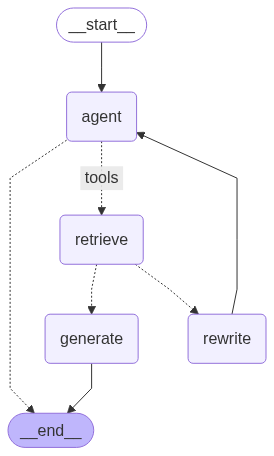

In [51]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
graph.invoke({"messages": "What is AI Agent?"})

---CALL AGENT---
---CHECK RELEVANCE---


/Users/beniaminenahid/Documents/Github Repo/Retrieval_Augmented_Generation_RAG/rag_venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is AI Agent?', additional_kwargs={}, response_metadata={}, id='653ff20f-6fb3-437e-a409-1824ef1d0524'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jVwQ0GjleGuTz2UiEyyV7nWW', 'function': {'arguments': '{"query":"What is AI Agent?"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 99, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C3mvR7wECSdN1OhmCSlBRBHYQBhAk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--021be521-c7b4-4b24-9ea4-e6b77cc4da59-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'What is

In [52]:
graph.invoke({"messages":"What is MCP"})

---CALL AGENT---
---CHECK RELEVANCE---


/Users/beniaminenahid/Documents/Github Repo/Retrieval_Augmented_Generation_RAG/rag_venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is MCP', additional_kwargs={}, response_metadata={}, id='468ddf32-fa2b-45b6-b363-735b9c380a11'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PCx1z7xf4fZJkwb1oDQUvsqU', 'function': {'arguments': '{"query":"MCP"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 97, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C3mucGY7wbqjSxsVORTzCpg9fUGwH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--967d50c8-3d68-4989-815e-40706128f1ce-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'MCP'}, 'id': 'call_PCx1z7xf

In [54]:
graph.invoke({"messages":"What is Model Context Protocol"})

---CALL AGENT---
---CHECK RELEVANCE---


/Users/beniaminenahid/Documents/Github Repo/Retrieval_Augmented_Generation_RAG/rag_venv/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is Model Context Protocol', additional_kwargs={}, response_metadata={}, id='edbb06d9-a2e7-4e68-a4dd-33527f407bd8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qDjqQHLFcFetbg28FPkmiGDz', 'function': {'arguments': '{"query":"Model Context Protocol"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 99, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C3mwB35eC0IYsDtCgMIbx68bl9mg8', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7da8dbff-8be6-4868-b7a7-f4c4fe92ec1a-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': 